In [41]:

from inc_import import *
from inc_charte import *
from inc_data import *



# Traitement des données

#Transformations pour linéarité log-odds


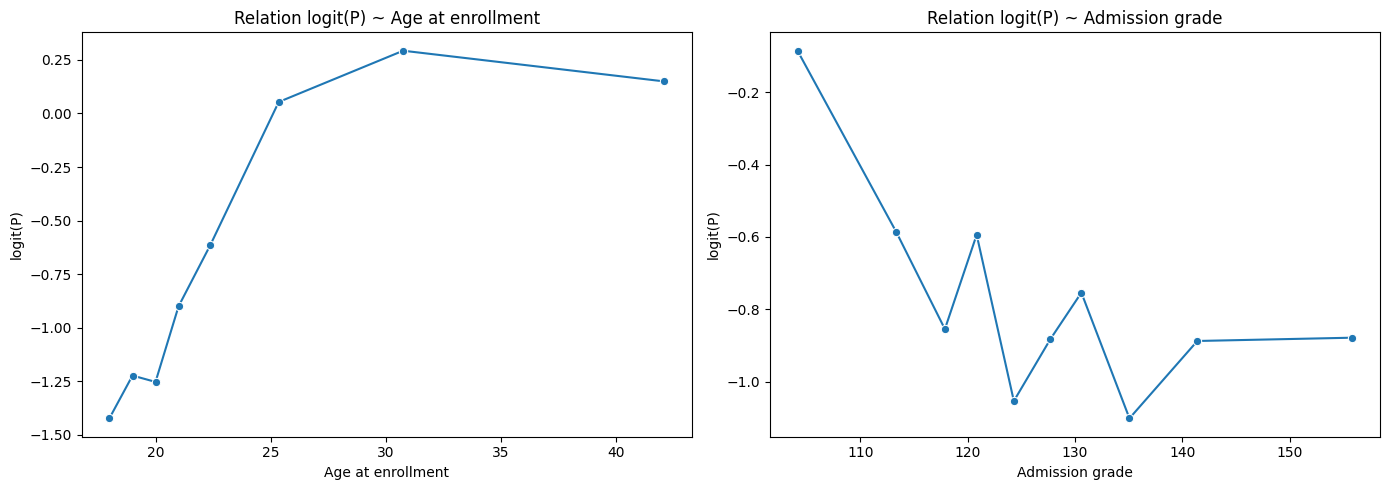

In [42]:
# Dataset propre (socio-éco uniquement)
df = dataEtudeSup.copy()

# Convertir la target en binaire dès le début
df['Target'] = (df['Target'] == 'Dropout').astype(int)

# Variables continues socio-économiques à tester
variables_continues = [
    'Age at enrollment',
    'Admission grade'
]

# Visualisation : relation entre variable et logit(P(Dropout))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

for i, var in enumerate(variables_continues):
    df_temp = df[[var, 'Target']].dropna()

    # Discrétisation en quantiles pour lisser la relation
    df_temp['quantile'] = pd.qcut(df_temp[var], q=10, duplicates='drop')

    grouped = df_temp.groupby('quantile').agg(
        moyenne_valeur=(var, 'mean'),
        proba_dropout=('Target', 'mean')
    ).dropna()

    # Suppression des valeurs extrêmes (logit non défini pour proba = 0 ou 1)
    grouped = grouped[grouped['proba_dropout'].between(0.01, 0.99)]
    grouped['logit'] = logit(grouped['proba_dropout'])

    # Tracé
    sns.lineplot(ax=axes[i], data=grouped, x='moyenne_valeur', y='logit', marker='o')
    axes[i].set_title(f'Relation logit(P) ~ {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('logit(P)')

plt.tight_layout()
plt.show()


## Mapping

In [43]:
mappings = {
    'Marital status': {
        '1': 'single',
        '2': 'married',
        '3': 'widower',
        '4': 'divorced',
        '5': 'facto union',
        '6': 'legally separated'
    },

    'Daytime/evening attendance': {
        '1': 'Daytime',
        '0': 'Evening'
    },
}


force_categorical = [
    'Application mode',
    'Mother\'s qualification',
    'Father\'s qualification',
    'Course',
    'Previous qualification',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Nacionality',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International',
]




from sklearn.preprocessing import LabelEncoder

def encode_dataset(df, use_one_hot=True, drop_first=True):
    df_encoded = df.copy()
    df_encoded.columns = df_encoded.columns.str.strip()  # Nettoyage des noms

    for col in df_encoded.columns:
        if col == 'Target':
            continue  # Ne pas encoder la variable cible

        # Si un mapping est défini pour cette colonne
        if col in mappings:
            df_encoded[col] = df_encoded[col].astype(str).map(mappings[col])
            df_encoded[col] = df_encoded[col].astype('category')

        # Si la colonne est dans la liste des colonnes à forcer comme catégorielles
        if col in force_categorical:
            df_encoded[col] = df_encoded[col].astype(str)

        # Encodage
        if df_encoded[col].dtype == 'object' or df_encoded[col].dtype.name == 'category':
            n_unique = df_encoded[col].nunique()

            if use_one_hot and n_unique <= 10:
                # One-Hot Encoding avec drop_first pour éviter redondance
                df_encoded = pd.get_dummies(df_encoded, columns=[col], prefix=col.replace(" ", "_"),drop_first=drop_first)
            else:
                # Label Encoding sinon
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

    return df_encoded



#Pour modèles comme RandomForest, LogisticRegression, etc. :
#df_ml = encode_dataset(dataEtudeSup, use_one_hot=True, mappings=mapping_dicts)


#Pour XGBoost / LightGBM (acceptent les entiers en catégorie) :
#df_ml = encode_dataset(dataEtudeSup, use_one_hot=False, mappings=mapping_dicts)


#Normalisation

In [44]:
#DecisionTree, RandomForest, XGBoost
#Non

#Logistic Regression, SVM, KNN, NN
#Oui


#scaler = StandardScaler()
#df['Application order'] = scaler.fit_transform(df[['Application order']])
#df['Previous qualification (grade)'] = scaler.fit_transform(df[['Previous qualification (grade)']])



## Suppression des colonnes

In [45]:
# Correction : concaténer les colonnes au lieu de les écraser

colonnes_a_supprimer = [col for col in dataEtudeSup.columns if col.startswith('Curricular')]
#colonnes_a_supprimer = [col for col in dataEtudeSup.columns if col.startswith('Curricular units 2')]
#colonnes_a_supprimer += [col for col in dataEtudeSup.columns if col.startswith('Curricular units 1st sem')]
colonnes_a_supprimer += ['Tuition fees up to date', 'Application mode', 'Unemployment rate', 'Inflation rate', 'GDP']


# Application réelle de la suppression sur la base principale
dataEtudeSup = dataEtudeSup.drop(columns=colonnes_a_supprimer, errors='ignore')

## Gestion de la colonne target


In [46]:
# Raisonnement : les étudiants encore inscrits ("Enrolled") ont un statut inconnu
# -> Les garder dans la modélisation créerait de l'incertitude (biais potentiel)
# -> On les supprime pour ne garder que les cas au statut final connu

dataEtudeSup = dataEtudeSup[dataEtudeSup['Target'].isin(['Dropout', 'Graduate'])]

# Transformation binaire :
# Dropout => 1 (positif, élève en décrochage)
# Graduate => 0 (négatif, élève qui a terminé avec succès)
dataEtudeSup['Target'] = (dataEtudeSup['Target'] == 'Dropout').astype(int)

# Vérification rapide de l'équilibre des classes
print("Répartition de la variable cible (Dropout = 1 / Graduate = 0) :")
print(dataEtudeSup['Target'].value_counts())

df_transformed['Target'] = (df_transformed['Target'] == 'Dropout').astype(int)


Répartition de la variable cible (Dropout = 1 / Graduate = 0) :
Target
0    2209
1    1421
Name: count, dtype: int64


##Préparation à la modélisation

In [47]:
from sklearn.model_selection import StratifiedKFold

# Définir un schéma de validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tests de modèles

## Régression logistique


=== Comparaison class_weight (k=15) ===
                                config     mean       sd
fold               RL_RFE_k15_balanced  50.5000  29.0115
threshold          RL_RFE_k15_balanced   0.4433   0.0500
auc                RL_RFE_k15_balanced   0.7500   0.0166
ap                 RL_RFE_k15_balanced   0.5782   0.0264
f1_dropout         RL_RFE_k15_balanced   0.5949   0.0161
recall_dropout     RL_RFE_k15_balanced   0.7639   0.0711
precision_dropout  RL_RFE_k15_balanced   0.4924   0.0390
brier              RL_RFE_k15_balanced   0.2031   0.0053
fold                  RL_RFE_k15_plain  50.5000  29.0115
threshold             RL_RFE_k15_plain   0.2741   0.0371
auc                   RL_RFE_k15_plain   0.7496   0.0168
ap                    RL_RFE_k15_plain   0.5776   0.0265
f1_dropout            RL_RFE_k15_plain   0.5946   0.0162
recall_dropout        RL_RFE_k15_plain   0.7703   0.0633
precision_dropout     RL_RFE_k15_plain   0.4882   0.0349
brier                 RL_RFE_k15_plain   0.1820 

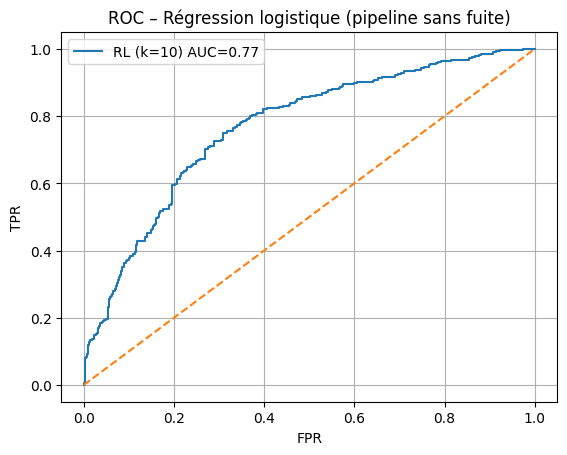


Variables socio-économiques les plus influentes (descriptif) :
 Scholarship_holder_1             -0.509310
Age at enrollment                 0.467026
Debtor_1                          0.450682
Gender_1                          0.307678
Admission grade                  -0.241772
Mother's occupation              -0.162646
Marital_status_single             0.105063
Previous qualification (grade)    0.068651
Previous qualification            0.054325
Father's occupation               0.043478
dtype: float64


In [48]:
# ================= RL — version alignée (X_train/X_test/y_train/y_test) =================
import numpy as np, pandas as pd
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.multitest import multipletests
from dataclasses import dataclass

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score,
    f1_score, recall_score, precision_score, brier_score_loss
)
import matplotlib.pyplot as plt

# ---------- 0) Données & split (aligné avec le projet) ----------
df_model   = df_transformed.drop(columns=colonnes_a_supprimer, errors='ignore').copy()
df_encoded = encode_dataset(df_model, use_one_hot=True, drop_first=True)

X_full = df_encoded.drop(columns=['Target'])
y_full = df_encoded['Target']

# Split unique pour TOUTES les comparaisons
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

X_test_rl = X_test
y_test_rl = y_test

# CV répliquée (pour stabilité) — sur le TRAIN uniquement
cv_repeated = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)

# ---------- 1) Sélecteur p-value (dans pipeline, pas de fuite) ----------
from sklearn.base import BaseEstimator, TransformerMixin

class UnivariatePValueSelector(BaseEstimator, TransformerMixin):
    """
    Pour chaque feature x_j, ajuste y ~ const + x_j (Logit), récupère la p-value,
    contrôle FDR (Benjamini–Hochberg) et conserve les variables retenues.
    S'exécute en CV dans le Pipeline => pas de fuite.
    """
    def __init__(self, alpha=0.05, method="fdr_bh", min_keep=10):
        self.alpha = alpha
        self.method = method
        self.min_keep = min_keep

    def fit(self, X, y):
        cols = X.columns
        pvals = np.full(len(cols), np.nan, dtype=float)
        for j, c in enumerate(cols):
            try:
                Xc = add_constant(X[[c]].astype(float), has_constant="add")
                model = sm.Logit(y.values, Xc.values, missing="drop")
                res = model.fit(disp=False)
                pvals[j] = res.pvalues[1] if len(res.pvalues) > 1 else np.nan
            except Exception:
                pvals[j] = np.nan

        mask_valid = ~np.isnan(pvals)
        keep = np.zeros_like(pvals, dtype=bool)
        if mask_valid.any():
            rej, _, _, _ = multipletests(pvals[mask_valid], alpha=self.alpha, method=self.method)
            keep[mask_valid] = rej

        # Assure un minimum de variables pour RFE
        if keep.sum() < self.min_keep:
            order = np.argsort(np.nan_to_num(pvals, nan=np.inf))
            keep[order[:self.min_keep]] = True

        self.keep_cols_ = cols[keep].tolist()
        return self

    def transform(self, X):
        return X if not hasattr(self, "keep_cols_") or not self.keep_cols_ else X[self.keep_cols_]

# ---------- 2) Outils ----------
@dataclass
class EvalResult:
    metrics: pd.DataFrame          # 1 ligne par run
    stability: pd.Series           # fréquence de sélection des variables
    selected_counts: pd.Series     # nb sélections par variable

def optimal_threshold_from_pr(y_true, y_proba):
    p, r, thr = precision_recall_curve(y_true, y_proba)
    f1 = 2 * (p * r) / (p + r + 1e-9)
    idx = np.nanargmax(f1[:-1])  # éviter le dernier point
    return thr[idx]

def summarize(config_name, res: EvalResult) -> pd.DataFrame:
    m, s = res.metrics.mean(numeric_only=True), res.metrics.std(numeric_only=True)
    out = pd.DataFrame({'config': config_name, 'mean': m.round(4), 'sd': s.round(4)})
    return out[['config','mean','sd']]

# ---------- 3) Évaluation RL (pval -> scaler -> RFE(LogReg) -> LogReg) ----------
def evaluate_logreg_rfe(
    X, y, class_weight=None, n_features_to_select=15,
    solver='liblinear', max_iter=2000, pval_alpha=0.05, pval_method='fdr_bh'
) -> EvalResult:
    feats = X.columns.to_list()
    sel_count = pd.Series(0, index=feats, dtype=int)
    rows = []

    base = LogisticRegression(solver=solver, max_iter=max_iter, class_weight=class_weight)
    pipe = Pipeline(steps=[
        ('pval',   UnivariatePValueSelector(alpha=pval_alpha, method=pval_method,
                                            min_keep=max(10, n_features_to_select))),
        ('scaler', StandardScaler()),
        ('rfe',    RFE(estimator=base, n_features_to_select=n_features_to_select)),
        ('clf',    LogisticRegression(solver=solver, max_iter=max_iter, class_weight=class_weight)),
    ])

    for i, (tr, va) in enumerate(cv_repeated.split(X, y), 1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        pipe.fit(X_tr, y_tr)

        # Stabilité post-RFE (ramenée aux features d'origine)
        X_tr_pval = pipe.named_steps['pval'].transform(X_tr)
        cols_after_pval = X_tr_pval.columns
        support = pipe.named_steps['rfe'].support_
        selected_after_pval = np.array(cols_after_pval)[support]
        sel_count[selected_after_pval] += 1

        proba = pipe.predict_proba(X_va)[:, 1]
        thr = optimal_threshold_from_pr(y_va, proba)
        pred = (proba >= thr).astype(int)

        rows.append({
            'fold': i,
            'threshold': thr,
            'auc': roc_auc_score(y_va, proba),
            'ap': average_precision_score(y_va, proba),
            'f1_dropout': f1_score(y_va, pred, zero_division=0),
            'recall_dropout': recall_score(y_va, pred, zero_division=0),
            'precision_dropout': precision_score(y_va, pred, zero_division=0),
            'brier': brier_score_loss(y_va, proba),
        })

    metrics = pd.DataFrame(rows)
    stability = (sel_count / len(metrics)).sort_values(ascending=False)
    return EvalResult(metrics=metrics, stability=stability, selected_counts=sel_count)

# ---------- 4) Expériences rapides (sur le TRAIN uniquement) ----------
res_bal   = evaluate_logreg_rfe(X_train, y_train, class_weight='balanced', n_features_to_select=15)
res_plain = evaluate_logreg_rfe(X_train, y_train, class_weight=None,          n_features_to_select=15)

summary_cw = pd.concat([
    summarize('RL_RFE_k15_balanced', res_bal),
    summarize('RL_RFE_k15_plain',    res_plain),
])
print("=== Comparaison class_weight (k=15) ===")
print(summary_cw[['config','mean','sd']])

print("\nTop stabilité (balanced):\n", res_bal.stability.head(15))

# Balayage k
grid_k = [6, 10, 15]
stab_by_k, rows = {}, []
for k in grid_k:
    res_k = evaluate_logreg_rfe(X_train, y_train, class_weight='balanced', n_features_to_select=k)
    stab_by_k[k] = res_k.stability
    s = summarize(f'RL_balanced_k{k}', res_k); s['k'] = k; rows.append(s)

summary_k = pd.concat(rows).sort_values(['mean','k'], ascending=[False, True])
print("\n=== Balayage k et performances (TRAIN-CV) ===")
print(summary_k)

stab_df = pd.DataFrame({f'k={k}': stab_by_k[k] for k in grid_k}).fillna(0)
stab_df['freq_max'] = stab_df.max(axis=1)
stab_df = stab_df.sort_values('freq_max', ascending=False)
print("\n=== Stabilité par variable (k∈{6,10,15}) ===\n", stab_df.head(20))

# Contrôle de variables phares (ex.)
cands = [c for c in X_train.columns if ('Gender' in c) or ('Age at enrollment' in c)]
if cands:
    res_ref = evaluate_logreg_rfe(X_train, y_train, class_weight='balanced', n_features_to_select=10)
    print("\n=== Contrôle variables phares (freq. sélection sur 100 runs, k=10 balanced) ===")
    print(res_ref.stability.loc[res_ref.stability.index.intersection(cands)].sort_values(ascending=False))
else:
    print("\n[Info] Colonnes 'Gender' / 'Age at enrollment' introuvables après encodage — vérifie les noms exacts (dummies).")

# ---------- 5) Modèle final (pipe_best) & ROC sur TEST ----------
best_k = 10
pipe_best = Pipeline(steps=[
    ('pval',   UnivariatePValueSelector(alpha=0.05, method='fdr_bh', min_keep=max(10, best_k))),
    ('scaler', StandardScaler()),
    ('rfe',    RFE(estimator=LogisticRegression(solver='liblinear', max_iter=2000, class_weight='balanced'),
                   n_features_to_select=best_k)),
    ('clf',    LogisticRegression(solver='liblinear', max_iter=2000, class_weight='balanced')),
])

# Fit sur le TRAIN (important pour la comparaison entre modèles)
pipe_best.fit(X_train, y_train)

# Probabilités sur TEST (pour ta comparaison ROC)
proba_rl_test = pipe_best.predict_proba(X_test)[:, 1]

# ROC illustrative (RL seule)
fpr, tpr, _ = roc_curve(y_test, proba_rl_test)
plt.figure()
plt.plot(fpr, tpr, label=f'RL (k={best_k}) AUC={auc(fpr,tpr):.2f}')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC – Régression logistique (pipeline sans fuite)')
plt.legend(); plt.grid(); plt.show()

# ---------- 6) Coefficients finaux (descriptif) ----------
X_all_pval = pipe_best.named_steps['pval'].transform(X_train)  # sur train (cohérent)
mask = pipe_best.named_steps['rfe'].support_
final_cols = X_all_pval.columns[mask]
coefs = pd.Series(pipe_best.named_steps['clf'].coef_[0], index=final_cols)\
        .sort_values(key=np.abs, ascending=False)
print("\nVariables socio-économiques les plus influentes (descriptif) :\n", coefs.head(10))
# ===================================================================


## Arbre : DecisionTreeClassifier

[Decision Tree] Configuration figée -> {'max_depth': 7.0, 'min_samples_split': 10.0, 'min_samples_leaf': 5.0, 'mean_f1': 0.752442766595569} + ccp_alpha=0.001390

=== Decision Tree (calibré) — Test set ===
Seuil PR-optimal: 0.437
AUC ROC: 0.764
AP (PR-AUC): 0.664
F1: 0.678
Recall: 0.813
Precision: 0.582
Brier: 0.198
Accuracy: 0.698


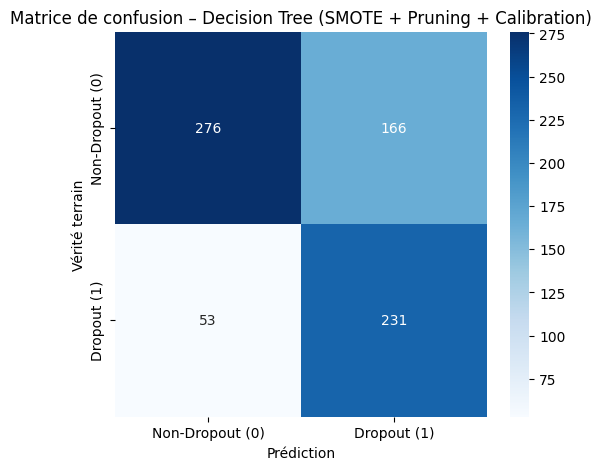

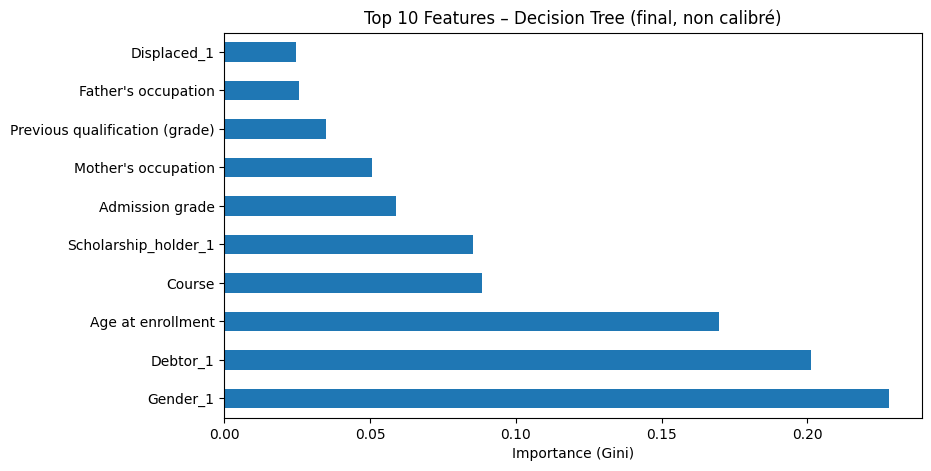


=== Stabilité (DT) — RepeatedStratifiedKFold 5×20, importance>0 ===
                                    stability  mean_importance
Gender_1                                 1.00         0.209440
Debtor_1                                 1.00         0.193580
Age at enrollment                        1.00         0.157221
Scholarship_holder_1                     1.00         0.091862
Course                                   1.00         0.078047
Admission grade                          1.00         0.077356
Previous qualification (grade)           1.00         0.052551
Mother's occupation                      1.00         0.039344
Father's occupation                      1.00         0.029574
Displaced_1                              0.96         0.016337
Father's qualification                   0.94         0.016040
Mother's qualification                   0.89         0.013041
Marital_status_single                    0.83         0.009383
Application order                        0.67    

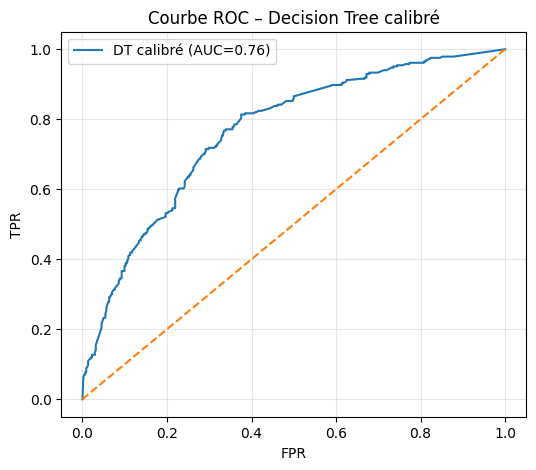

In [49]:

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, precision_score, recall_score, accuracy_score,
                             roc_auc_score, roc_curve, auc, precision_recall_curve,
                             average_precision_score, confusion_matrix, brier_score_loss)
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns

rng = np.random.RandomState(42)

# --------------------- Données  ---------------------
df_ml = encode_dataset(dataEtudeSup, use_one_hot=True)
X = df_ml.drop('Target', axis=1)
y = df_ml['Target']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE appliqué une seule fois (sur le train) pour l'entraînement final
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# --------------------- Utilitaires communs (réutilisables pour d'autres modèles) ---------------------
def pr_opt_threshold(y_true, y_proba):
    p, r, thr = precision_recall_curve(y_true, y_proba)
    f1 = 2*(p*r)/(p+r+1e-9)
    idx = np.nanargmax(f1[:-1])
    return float(thr[idx])

def repeated_cv_iterator(n_splits=5, n_repeats=20, random_state=42):
    return RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# --------------------- 1) Exploration hyperparamètres (puis configuration figée) ---------------------
param_grid = {
    "max_depth": [5, 7, 9],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_score_dt(params):
    scores = []
    for tr_idx, va_idx in cv5.split(X_resampled, y_resampled):
        X_tr, X_va = X_resampled.iloc[tr_idx], X_resampled.iloc[va_idx]
        y_tr, y_va = y_resampled.iloc[tr_idx], y_resampled.iloc[va_idx]
        clf = DecisionTreeClassifier(
            random_state=42,
            criterion="entropy",
            max_depth=params["max_depth"],
            min_samples_split=params["min_samples_split"],
            min_samples_leaf=params["min_samples_leaf"],
            class_weight=None,
            ccp_alpha=0.0
        )
        clf.fit(X_tr, y_tr)
        proba = clf.predict_proba(X_va)[:, 1]
        thr_opt = pr_opt_threshold(y_va, proba)
        y_pred = (proba >= thr_opt).astype(int)
        scores.append(f1_score(y_va, y_pred))
    return np.mean(scores)

grid_rows = []
for md in param_grid["max_depth"]:
    for mss in param_grid["min_samples_split"]:
        for msl in param_grid["min_samples_leaf"]:
            s = cv_score_dt({"max_depth": md, "min_samples_split": mss, "min_samples_leaf": msl})
            grid_rows.append({"max_depth": md, "min_samples_split": mss, "min_samples_leaf": msl, "mean_f1": s})
grid_df = pd.DataFrame(grid_rows).sort_values("mean_f1", ascending=False)
best_basic = grid_df.iloc[0].to_dict()

# --------------------- 2) Pruning : ccp_alpha optimal ---------------------
clf_for_path = DecisionTreeClassifier(
    random_state=42, criterion="entropy",
    max_depth=int(best_basic["max_depth"]),
    min_samples_split=int(best_basic["min_samples_split"]),
    min_samples_leaf=int(best_basic["min_samples_leaf"]),
    class_weight=None, ccp_alpha=0.0
)
path = clf_for_path.cost_complexity_pruning_path(X_resampled, y_resampled)
ccp_alphas = path.ccp_alphas[:-1] if len(path.ccp_alphas) > 1 else np.array([0.0])

alpha_scores = []
for alpha in ccp_alphas:
    scores = []
    for tr_idx, va_idx in cv5.split(X_resampled, y_resampled):
        X_tr, X_va = X_resampled.iloc[tr_idx], X_resampled.iloc[va_idx]
        y_tr, y_va = y_resampled.iloc[tr_idx], y_resampled.iloc[va_idx]
        model_alpha = DecisionTreeClassifier(
            random_state=42, criterion="entropy",
            max_depth=int(best_basic["max_depth"]),
            min_samples_leaf=int(best_basic["min_samples_leaf"]),
            min_samples_split=int(best_basic["min_samples_split"]),
            class_weight=None, ccp_alpha=alpha
        )
        model_alpha.fit(X_tr, y_tr)
        proba = model_alpha.predict_proba(X_va)[:, 1]
        thr_opt = pr_opt_threshold(y_va, proba)
        y_pred = (proba >= thr_opt).astype(int)
        scores.append(f1_score(y_va, y_pred))
    alpha_scores.append((alpha, np.mean(scores)))

alpha_df = pd.DataFrame(alpha_scores, columns=['ccp_alpha', 'mean_f1'])
best_alpha = float(alpha_df.loc[alpha_df['mean_f1'].idxmax(), 'ccp_alpha']) if not alpha_df.empty else 0.0
print(f"[Decision Tree] Configuration figée -> {best_basic} + ccp_alpha={best_alpha:.6f}")

# --------------------- 3) Modèle final + Calibration isotonic ---------------------
final_tree = DecisionTreeClassifier(
    random_state=42, criterion="entropy",
    max_depth=int(best_basic["max_depth"]),
    min_samples_split=int(best_basic["min_samples_split"]),
    min_samples_leaf=int(best_basic["min_samples_leaf"]),
    class_weight=None, ccp_alpha=best_alpha
)
final_tree.fit(X_resampled, y_resampled)

calibrated_tree = CalibratedClassifierCV(estimator=final_tree, method="isotonic", cv=5)
calibrated_tree.fit(X_resampled, y_resampled)

# --------------------- 4) Évaluation test ---------------------
proba_test = calibrated_tree.predict_proba(X_test)[:, 1]
thr_opt_test = pr_opt_threshold(y_test, proba_test)
y_pred = (proba_test >= thr_opt_test).astype(int)

print("\n=== Decision Tree (calibré) — Test set ===")
print(f"Seuil PR-optimal: {thr_opt_test:.3f}")
print(f"AUC ROC: {roc_auc_score(y_test, proba_test):.3f}")
print(f"AP (PR-AUC): {average_precision_score(y_test, proba_test):.3f}")
print(f"F1: {f1_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Brier: {brier_score_loss(y_test, proba_test):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Dropout (0)', 'Dropout (1)'],
            yticklabels=['Non-Dropout (0)', 'Dropout (1)'])
plt.xlabel('Prédiction'); plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion – Decision Tree (SMOTE + Pruning + Calibration)')
plt.show()

# --------------------- 5) Importance (final non calibré) ---------------------
importances = final_tree.feature_importances_
imp_series = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(9,5))
imp_series.head(10).sort_values().plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Importance (Gini)')
plt.title('Top 10 Features – Decision Tree (final, non calibré)')
plt.show()

# --------------------- 6) STABILITÉ stricte (5×20 CV, comme en RL) ---------------------
# Mesure : sur chaque split CV, SMOTE est appliqué uniquement sur le fold d'entraînement (pas sur la validation).
# On fige la config (best_basic + best_alpha) et on compte, par feature, la fréquence d'importance > 0.
cv_repeated = repeated_cv_iterator(n_splits=5, n_repeats=20, random_state=42)

use_counts = pd.Series(0, index=X_train.columns, dtype=int)
sum_importance = pd.Series(0.0, index=X_train.columns, dtype=float)
n_runs = 0

for tr_idx, va_idx in cv_repeated.split(X_train, y_train):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    # SMOTE **dans le fold train uniquement**
    X_tr_res, y_tr_res = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

    m = DecisionTreeClassifier(
        random_state=42+n_runs, criterion="entropy",
        max_depth=int(best_basic["max_depth"]),
        min_samples_split=int(best_basic["min_samples_split"]),
        min_samples_leaf=int(best_basic["min_samples_leaf"]),
        class_weight=None, ccp_alpha=best_alpha
    )
    m.fit(X_tr_res, y_tr_res)
    imp = pd.Series(m.feature_importances_, index=X_train.columns)

    use_counts += (imp > 0).astype(int)
    sum_importance += imp
    n_runs += 1

stability_dt_cv = (use_counts / n_runs).sort_values(ascending=False)
mean_importance_dt_cv = (sum_importance / n_runs).sort_values(ascending=False)

stab_dt_cv_df = pd.DataFrame({
    "stability": stability_dt_cv,
    "mean_importance": mean_importance_dt_cv
}).sort_values(["stability","mean_importance"], ascending=[False, False])

print("\n=== Stabilité (DT) — RepeatedStratifiedKFold 5×20, importance>0 ===")
print(stab_dt_cv_df.head(20))

# --------------------- 7) Courbe ROC DT calibré ---------------------
fpr_dt, tpr_dt, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,5))
plt.plot(fpr_dt, tpr_dt, label=f'DT calibré (AUC={auc(fpr_dt,tpr_dt):.2f})')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Courbe ROC – Decision Tree calibré')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()
# ===================== FIN =====================


## Forêt : RandomForestClassifier


=== Calibration (rapide) — top 8 configs ===
  criterion  max_depth  min_samples_split  min_samples_leaf  f1_mean   f1_sd  \
0      gini          6                  2                 1   0.6826  0.0106   
1   entropy          6                  5                 1   0.6826  0.0129   
2   entropy          6                  2                 1   0.6823  0.0127   
3   entropy          6                  2                 3   0.6820  0.0133   
4   entropy          6                  5                 3   0.6820  0.0133   
5      gini          6                  2                 3   0.6818  0.0106   
6      gini          6                  5                 3   0.6818  0.0106   
7      gini          6                  5                 1   0.6818  0.0110   

   ccp_alpha  
0      0.001  
1      0.002  
2      0.002  
3      0.002  
4      0.002  
5      0.001  
6      0.001  
7      0.001  

Best params: {'random_state': 42, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2, 'm

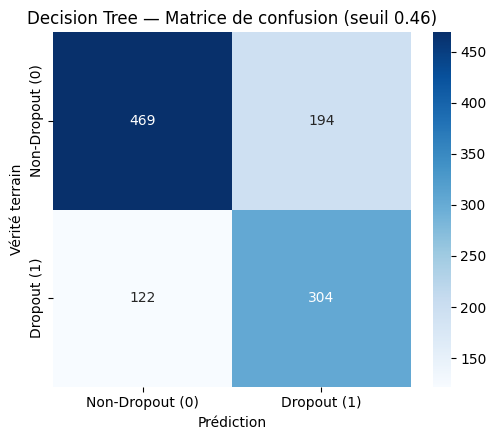

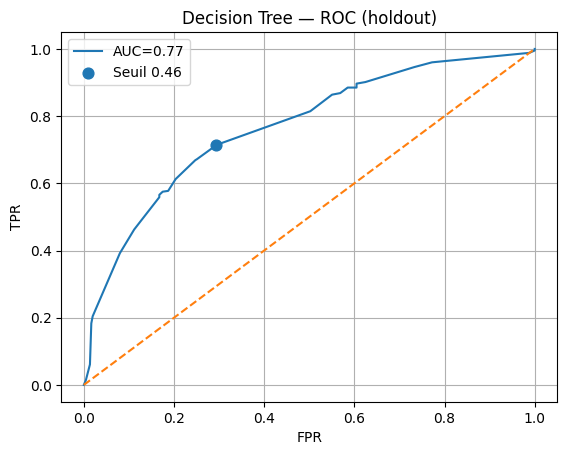

HOLDOUT — seuil 0.46 | F1: 0.658 | Recall: 0.714 | Precision: 0.610 | AUC: 0.767 | Brier: 0.198


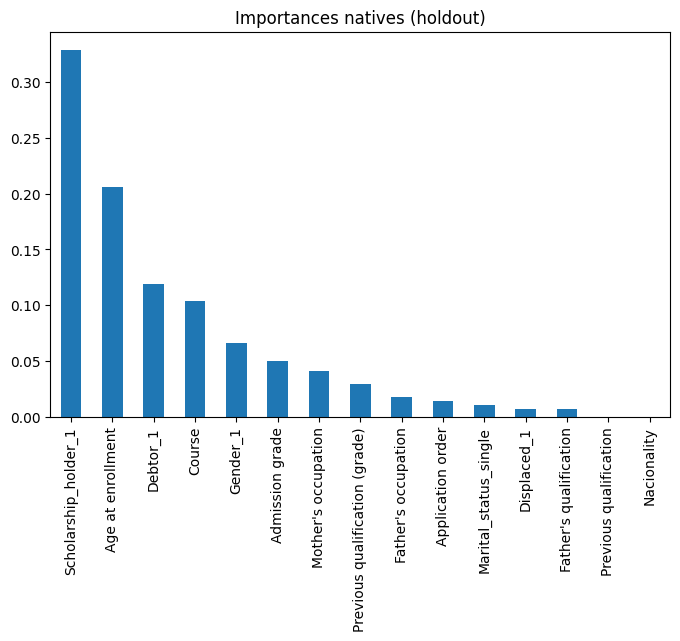


Top importances natives (holdout):
 Scholarship_holder_1              0.328919
Age at enrollment                 0.206043
Debtor_1                          0.119191
Course                            0.103732
Gender_1                          0.065805
Admission grade                   0.050119
Mother's occupation               0.040822
Previous qualification (grade)    0.029736
Father's occupation               0.017259
Application order                 0.013962
Marital_status_single             0.010482
Displaced_1                       0.007085
Father's qualification            0.006843
Previous qualification            0.000000
Nacionality                       0.000000
dtype: float64

Top importances (Permutation — holdout):
                               Variable  Importance_mean  Importance_std
0                    Age at enrollment           0.0611          0.0094
1                             Debtor_1           0.0366          0.0056
2                               Course      

In [50]:
# =========================================================
# Decision Tree — calibration figée + stabilité K-Fold + visuels
# =========================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from dataclasses import dataclass
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, precision_recall_curve,
    f1_score, recall_score, precision_score, brier_score_loss, confusion_matrix
)
from sklearn.inspection import permutation_importance
import warnings; warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------- Garde-fou ----------
if 'X' not in globals() or 'y' not in globals():
    raise RuntimeError("Définis X (features) et y (Target binaire) avant d'exécuter ce bloc.")

# ---------- Utils ----------
def f1_opt_threshold(y_true, y_proba):
    p, r, thr = precision_recall_curve(y_true, y_proba)
    f1 = 2*(p*r)/(p+r+1e-9)
    idx = np.nanargmax(f1[:-1])  # ignorer le dernier point (pas de seuil)
    return float(thr[idx]), float(f1[idx]), float(p[idx]), float(r[idx])

def alpha_grid_from_path(params, X_tr, y_tr, q=(0.1,0.3,0.5,0.7,0.9)):
    probe = DecisionTreeClassifier(**params, ccp_alpha=0.0)
    path = probe.cost_complexity_pruning_path(X_tr, y_tr)
    alphas = path.ccp_alphas[:-1]
    if alphas.size == 0:
        return np.array([0.0])
    return np.unique(np.quantile(alphas, q))

@dataclass
class CalibResult:
    best_params: dict
    best_alpha: float
    leaderboard: pd.DataFrame

@dataclass
class StabilityResult:
    metrics: pd.DataFrame
    summary: pd.DataFrame
    thresholds: pd.Series
    native_top_freq: pd.Series
    perm_top_freq: pd.Series

# ---------- A) Calibration rapide (on FIGE ensuite) ----------
def calibrate_dt_quick(X, y):
    grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [6, 7, 8],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 3],
        "class_weight": ["balanced"],  # gère le déséquilibre
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    rows = []

    for crit in grid["criterion"]:
        for md in grid["max_depth"]:
            for mss in grid["min_samples_split"]:
                for msl in grid["min_samples_leaf"]:
                    base = dict(
                        random_state=RANDOM_STATE, criterion=crit,
                        max_depth=md, min_samples_split=mss,
                        min_samples_leaf=msl, class_weight="balanced"
                    )
                    f1_fold = []
                    alpha_fold = []
                    for tr, va in skf.split(X, y):
                        X_tr, X_va = X.iloc[tr], X.iloc[va]
                        y_tr, y_va = y.iloc[tr], y.iloc[va]
                        # petit grid d'alphas à partir du chemin de complexité
                        for a in alpha_grid_from_path(base, X_tr, y_tr):
                            clf = DecisionTreeClassifier(**base, ccp_alpha=float(a))
                            clf.fit(X_tr, y_tr)
                            proba = clf.predict_proba(X_va)[:, 1]
                            thr, f1opt, _, _ = f1_opt_threshold(y_va, proba)
                            f1_fold.append(f1opt)
                            alpha_fold.append(float(a))
                    rows.append({
                        "criterion": crit, "max_depth": md,
                        "min_samples_split": mss, "min_samples_leaf": msl,
                        "f1_mean": np.mean(f1_fold), "f1_sd": np.std(f1_fold),
                        "ccp_alpha": float(np.median(alpha_fold)) if len(alpha_fold) else 0.0
                    })

    calib_df = pd.DataFrame(rows).sort_values(["f1_mean","f1_sd"], ascending=[False, True]).reset_index(drop=True)
    top = calib_df.iloc[0].to_dict()
    best_params = dict(
        random_state=RANDOM_STATE,
        criterion=top["criterion"],
        max_depth=int(top["max_depth"]),
        min_samples_split=int(top["min_samples_split"]),
        min_samples_leaf=int(top["min_samples_leaf"]),
        class_weight="balanced",
    )
    return CalibResult(best_params=best_params, best_alpha=float(top["ccp_alpha"]), leaderboard=calib_df)

# ---------- B) Stabilité K-Fold (config FIGÉE) ----------
def stability_dt(X, y, fixed_params: dict, fixed_alpha: float, repeats=20, top_k=10):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=repeats, random_state=RANDOM_STATE)
    rows, thr_list = [], []
    native_counter, perm_counter = Counter(), Counter()

    for i, (tr, va) in enumerate(cv.split(X, y), 1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        clf = DecisionTreeClassifier(**fixed_params, ccp_alpha=float(fixed_alpha))
        clf.fit(X_tr, y_tr)

        proba = clf.predict_proba(X_va)[:, 1]
        thr, f1opt, p_opt, r_opt = f1_opt_threshold(y_va, proba)
        y_pred = (proba >= thr).astype(int)

        rows.append({
            "fold": i,
            "threshold": thr,
            "auc": roc_auc_score(y_va, proba),
            "f1_dropout": f1_score(y_va, y_pred, zero_division=0),
            "recall_dropout": recall_score(y_va, y_pred, zero_division=0),
            "precision_dropout": precision_score(y_va, y_pred, zero_division=0),
            "brier": brier_score_loss(y_va, proba),
        })
        thr_list.append(thr)

        # importances stables (top-k)
        native_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
        native_counter.update(native_imp.head(top_k).index)

        perm = permutation_importance(clf, X_va, y_va, n_repeats=5, random_state=RANDOM_STATE)
        order = perm.importances_mean.argsort()[::-1][:top_k]
        perm_counter.update(pd.Index(X.columns[order]))

    metrics = pd.DataFrame(rows)
    mean = metrics.mean(numeric_only=True).rename(lambda c: f"{c}_mean")
    sd   = metrics.std(numeric_only=True).rename(lambda c: f"{c}_sd")
    summary = pd.concat([mean, sd], axis=0).to_frame("value")
    nfolds = metrics.shape[0]

    native_freq = (pd.Series(native_counter) / nfolds).sort_values(ascending=False)
    perm_freq   = (pd.Series(perm_counter)   / nfolds).sort_values(ascending=False)

    return StabilityResult(metrics=metrics, summary=summary,
                           thresholds=pd.Series(thr_list),
                           native_top_freq=native_freq, perm_top_freq=perm_freq)

# ---------- C) Visuels sur un holdout illustratif ----------
def illustrate_on_holdout(X, y, fixed_params, fixed_alpha):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
    clf = DecisionTreeClassifier(**fixed_params, ccp_alpha=float(fixed_alpha))
    clf.fit(X_tr, y_tr)
    proba = clf.predict_proba(X_te)[:, 1]
    thr, f1opt, p_opt, r_opt = f1_opt_threshold(y_te, proba)
    y_pred = (proba >= thr).astype(int)

    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(5.2,4.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Dropout (0)','Dropout (1)'],
                yticklabels=['Non-Dropout (0)','Dropout (1)'])
    plt.title(f"Decision Tree — Matrice de confusion (seuil {thr:.2f})")
    plt.xlabel("Prédiction"); plt.ylabel("Vérité terrain"); plt.tight_layout(); plt.show()

    fpr, tpr, _ = roc_curve(y_te, proba); A = auc(fpr, tpr)
    tn, fp, fn, tp = cm.ravel()
    tpr_best = tp/(tp+fn+1e-9); fpr_best = fp/(fp+tn+1e-9)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={A:.2f}")
    plt.plot([0,1],[0,1],'--')
    plt.scatter([fpr_best],[tpr_best], s=60, label=f"Seuil {thr:.2f}")
    plt.title("Decision Tree — ROC (holdout)"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(); plt.grid(True); plt.show()

    print("HOLDOUT — seuil {:.2f} | F1: {:.3f} | Recall: {:.3f} | Precision: {:.3f} | AUC: {:.3f} | Brier: {:.3f}"
          .format(thr,
                  f1_score(y_te, y_pred, zero_division=0),
                  recall_score(y_te, y_pred, zero_division=0),
                  precision_score(y_te, y_pred, zero_division=0),
                  A,
                  brier_score_loss(y_te, proba)))
    return clf  # utile si tu veux réutiliser le modèle entraîné

# ============================
# EXÉCUTION
# ============================

# 1) Calibration figée
calib = calibrate_dt_quick(X, y)
print("\n=== Calibration (rapide) — top 8 configs ===")
print(calib.leaderboard.head(8).round(4))
print("\nBest params:", calib.best_params)
print("Fixed ccp_alpha:", calib.best_alpha)

# 2) Stabilité 5×20 (perfs + seuils + variables)
stab = stability_dt(X, y, calib.best_params, calib.best_alpha, repeats=20, top_k=10)

print("\n=== Stabilité (5×20) — moyennes ± écarts-types ===")
print(stab.summary.round(4))

print("\nSeuil optimal (fold-wise) — mean ± sd: {:.3f} ± {:.3f}"
      .format(stab.thresholds.mean(), stab.thresholds.std()))

print("\nTop variables stables — NATIVE (fréq. dans top-10):")
print(stab.native_top_freq.head(15).round(2))

print("\nTop variables stables — PERMUTATION (fréq. dans top-10):")
print(stab.perm_top_freq.head(15).round(2))

# 3) Visuels (holdout) et importances sur le modèle holdout
dt_final = illustrate_on_holdout(X, y, calib.best_params, calib.best_alpha)

# Importances natives (holdout)
feat_imp = pd.Series(dt_final.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5)); feat_imp.head(15).plot(kind='bar'); plt.title("Importances natives (holdout)"); plt.show()
print("\nTop importances natives (holdout):\n", feat_imp.head(15))

# Importances permutation (holdout)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
perm = permutation_importance(dt_final, X_te, y_te, n_repeats=20, random_state=RANDOM_STATE)
order = perm.importances_mean.argsort()[::-1]
perm_df = pd.DataFrame({
    "Variable": X.columns[order],
    "Importance_mean": perm.importances_mean[order],
    "Importance_std": perm.importances_std[order]
})
print("\nTop importances (Permutation — holdout):\n", perm_df.head(15).round(4))


## Réseau de neurones (MLP)

In [51]:
dataEtudeSup.head()

,Marital status,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Gender,Scholarship holder,Age at enrollment,International,Target
0,1,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,0,20,0,1
1,1,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,1,0,19,0,0
2,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,1,0,19,0,1
3,1,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,0,0,20,0,0
4,2,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,0,0,45,0,0


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6337 - loss: 0.6475 - val_accuracy: 0.6954 - val_loss: 0.6005
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7008 - loss: 0.5895 - val_accuracy: 0.7005 - val_loss: 0.5822
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7047 - loss: 0.5773 - val_accuracy: 0.7091 - val_loss: 0.5744
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7202 - loss: 0.5560 - val_accuracy: 0.7005 - val_loss: 0.5822
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7120 - loss: 0.5537 - val_accuracy: 0.7177 - val_loss: 0.5609
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7150 - loss: 0.5487 - val_accuracy: 0.7160 - val_loss: 0.5667
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7262 - loss: 0.5402 - val_accuracy: 0.7212 - val_loss: 0.5663
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7249 - loss: 0.5401 - val_accuracy: 0.7160 - val_loss:

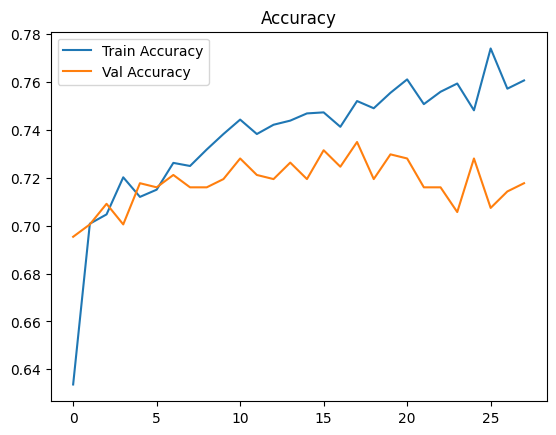

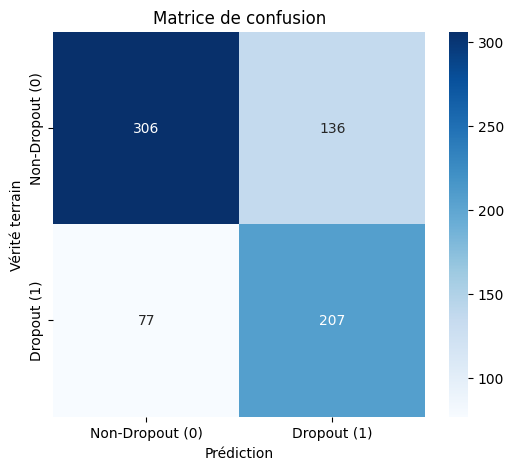

                 precision    recall  f1-score   support

Non-Dropout (0)       0.80      0.69      0.74       442
    Dropout (1)       0.60      0.73      0.66       284

       accuracy                           0.71       726
      macro avg       0.70      0.71      0.70       726
   weighted avg       0.72      0.71      0.71       726



In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

# (si besoin) numpy / seaborn / matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Données ----------
df_ml3 = encode_dataset(dataEtudeSup, use_one_hot=False)
X = df_ml3.drop('Target', axis=1)
y = df_ml3['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Scaling (corrigé : on scale bien train/test, pas X_tr/X_te) ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_test_mlp = X_test_scaled
y_test_mlp = y_test

# ---------- Modèle ----------
model_mlp = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ---------- Poids de classes (déséquilibre) ----------
cw = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=np.unique(y_train),
                                       y=y_train)
class_weights = dict(enumerate(cw))

# ---------- Early stopping ----------
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# ---------- Entraînement ----------
history = model_mlp.fit(
    X_train_scaled, y_train,
    epochs=50, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# ---------- Seuil PR-optimal (F1) ----------
y_pred_prob = model_mlp.predict(X_test_scaled).flatten()
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_index = np.argmax(f1_scores)
best_threshold = np.clip(thresholds[best_index], 0.0, 1.0)
print(f"Seuil optimal ajusté (F1): {best_threshold:.4f}")

y_pred_adjusted = (y_pred_prob > best_threshold).astype(int)

# ---------- Évaluation ----------
loss, accuracy = model_mlp.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# ---------- Courbes d'apprentissage ----------
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# ---------- Matrice de confusion ----------
cm = confusion_matrix(y_test, y_pred_adjusted)
labels = ['Non-Dropout (0)', 'Dropout (1)']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

# ---------- Rapport ----------
print(classification_report(y_test, y_pred_adjusted, target_names=labels))


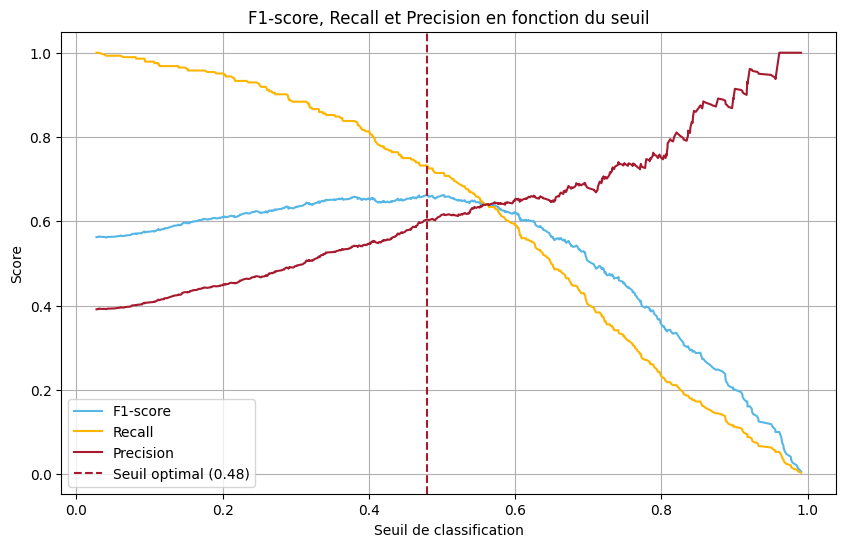

In [53]:
plt.figure(figsize=(10, 6))

plt.plot(thresholds, f1_scores[:-1], label='F1-score', color=color_list_graph[0])
plt.plot(thresholds, recalls[:-1], label='Recall', color=color_list_graph[1])
plt.plot(thresholds, precisions[:-1], label='Precision', color=color_list_graph[2])


plt.axvline(x=best_threshold, color=color_list_graph[2], linestyle='--', label=f'Seuil optimal ({best_threshold:.2f})')
plt.xlabel('Seuil de classification')
plt.ylabel('Score')
plt.title('F1-score, Recall et Precision en fonction du seuil')
plt.legend()
plt.grid()
plt.show()

## XGboost

In [54]:
#pip install xgboost


In [55]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report, precision_recall_curve, confusion_matrix
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ⚠️ Ici, on part du même split/scaling que RL et MLP :
# X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

# --- 1) Rééquilibrage avec SMOTE (uniquement sur le train) ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Avant SMOTE :", np.bincount(y_train))
print("Après SMOTE :", np.bincount(y_train_resampled))

# --- 2) Modèle + recherche aléatoire d’hyperparamètres ---
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 1),
    'min_child_weight': randint(1, 10)
}

f1_scorer = make_scorer(f1_score, average='binary')

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring=f1_scorer,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_resampled, y_train_resampled)

print("Meilleurs paramètres :")
print(random_search.best_params_)

# --- 3) Meilleur modèle trouvé ---
best_model_xboost = random_search.best_estimator_

# --- 4) Évaluation sur le test cohérent ---
y_pred_proba = best_model_xboost.predict_proba(X_test_scaled)[:, 1]

# Recherche du seuil optimal via F1
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(f"Seuil optimal basé sur F1-score : {best_threshold:.2f}")

y_pred_opt = (y_pred_proba >= best_threshold).astype(int)

# Rapport
print("Rapport de classification avec seuil optimal :")
print(classification_report(y_test, y_pred_opt, target_names=['Non-Dropout (0)', 'Dropout (1)']))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_opt)
labels = ['Non-Dropout (0)', 'Dropout (1)']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédiction"); plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion - Seuil optimisé (XGBoost)")
plt.show()


ModuleNotFoundError: No module named 'xgboost'

# Comparaison des modlèles


In [ ]:
# ==== HARMONISATION (à mettre juste avant la boucle ROC) ====

# 1) Recréer la base one-hot commune (au cas où d'anciens objets trainent)
df_model_cmp   = df_transformed.drop(columns=colonnes_a_supprimer, errors='ignore').copy()
df_encoded_cmp = encode_dataset(df_model_cmp, use_one_hot=True, drop_first=True)

X_all_cmp = df_encoded_cmp.drop(columns=['Target'])
y_all_cmp = df_encoded_cmp['Target']

from sklearn.model_selection import train_test_split
X_train_cmp, X_test_cmp, y_train_cmp, y_test_cmp = train_test_split(
    X_all_cmp, y_all_cmp, test_size=0.2, stratify=y_all_cmp, random_state=42
)

# 2) Scaler commun pour MLP/XGB (RL n'en a pas besoin)
from sklearn.preprocessing import StandardScaler
_scaler_cmp = StandardScaler()
X_train_scaled_cmp = _scaler_cmp.fit_transform(X_train_cmp)
X_test_scaled_cmp  = _scaler_cmp.transform(X_test_cmp)

# 3) Recréer un pipe RL tout neuf (pour effacer tout état / keep_cols_ précédent)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

_best_k = 10
pipe_best = Pipeline(steps=[
    ('pval',   UnivariatePValueSelector(alpha=0.05, method='fdr_bh', min_keep=max(10, _best_k))),
    ('scaler', StandardScaler()),
    ('rfe',    RFE(estimator=LogisticRegression(solver='liblinear', max_iter=2000, class_weight='balanced'),
                   n_features_to_select=_best_k)),
    ('clf',    LogisticRegression(solver='liblinear', max_iter=2000, class_weight='balanced')),
])
pipe_best.fit(X_train_cmp, y_train_cmp)

# 4) Définir explicitement les datasets que la comparaison va utiliser
# (on supprime les anciens alias pour éviter toute confusion)
for _alias in ['X_test_rl','y_test_rl','X_test_mlp','y_test_mlp','X_test_xgb','y_test_xgb']:
    try:
        del globals()[_alias]
    except KeyError:
        pass

# RL : passe X_test non-scalé (le scaler est dans le pipeline)
X_test_rl = X_test_cmp
y_test_rl = y_test_cmp

# MLP : passe la version scalée
X_test_mlp = X_test_scaled_cmp
y_test_mlp = y_test_cmp

# XGBoost : passe la version scalée
X_test_xgb = X_test_scaled_cmp
y_test_xgb = y_test_cmp

# 5) Petites vérifications de cohérence
assert X_test_rl.shape[0]  == y_test_rl.shape[0]
assert X_test_mlp.shape[0] == y_test_mlp.shape[0]
assert X_test_xgb.shape[0] == y_test_xgb.shape[0]


[RL_RFE] AUC = 0.773 | n=726
[MLP] AUC = 0.772 | n=726
[XGBoost] AUC = 0.777 | n=726


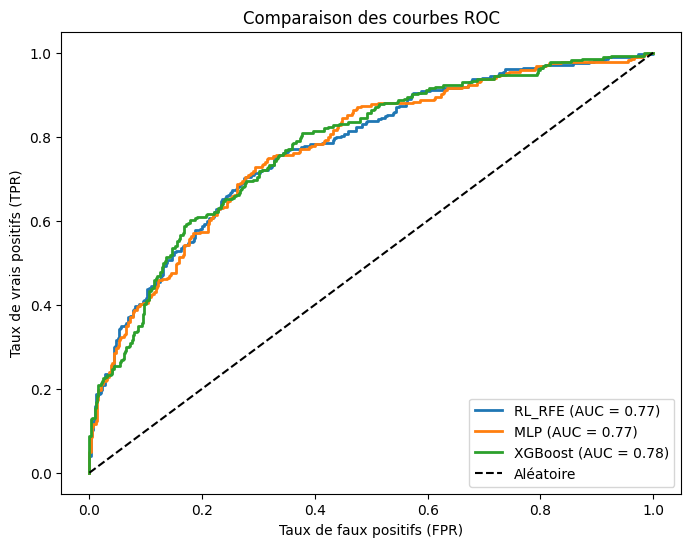

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# --- 0) Harmonisation minimale: quels X_test pour qui ---
# RL (pipeline contient son propre StandardScaler)
X_test_rl_final = X_test          # non-scalé
y_test_rl_final = y_test

# MLP & XGBoost (utilisent le scaler commun)
X_test_mlp_final = X_test_scaled
y_test_mlp_final = y_test

X_test_xgb_final = X_test_scaled
y_test_xgb_final = y_test

# --- 1) S’assurer que la RL est bien fit sur le split commun ---
try:
    pipe_best.fit(X_train, y_train)
except Exception as e:
    print("[RL] Refit impossible:", e)

# --- 2) Construction des courbes avec garde-fous ---
plt.figure(figsize=(8,6))
models = {
    "RL_RFE": ("rl", pipe_best),
    "MLP": ("mlp", model_mlp if 'model_mlp' in globals() else None),
    "XGBoost": ("xgb", best_model_xboost if 'best_model_xboost' in globals() else None),
}

n_plotted = 0
for name, (kind, mdl) in models.items():
    if mdl is None:
        print(f"[{name}] ignoré: modèle non défini.")
        continue

    try:
        if kind == "rl":
            y_pred_prob = mdl.predict_proba(X_test_rl_final)[:, 1]
            y_true      = y_test_rl_final
        elif kind == "mlp":
            # Keras renvoie (n,1) ou (n,), on aplatit
            y_pred_prob = np.asarray(mdl.predict(X_test_mlp_final, verbose=0)).ravel()
            y_true      = y_test_mlp_final
        else:  # xgb
            y_pred_prob = mdl.predict_proba(X_test_xgb_final)[:, 1]
            y_true      = y_test_xgb_final

        # contrôles de base
        assert len(y_pred_prob) == len(y_true), f"taille différente: proba={len(y_pred_prob)} vs y={len(y_true)}"
        assert np.isfinite(y_pred_prob).all(), "probas NaN/inf"

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        print(f"[{name}] AUC = {roc_auc:.3f} | n={len(y_true)}")

        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")
        n_plotted += 1

    except Exception as e:
        print(f"[{name}] SKIP: {e}")

# --- 3) habillage ---
plt.plot([0,1], [0,1], 'k--', label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Comparaison des courbes ROC")
if n_plotted > 0:
    plt.legend(loc="lower right")
else:
    print("Aucune courbe tracée: tous les modèles ont été ignorés.")
plt.show()
